In [2]:
import numpy as np
import scipy.optimize as spopt
from scipy.constants import hbar

In [9]:
import sqil_core as sqil

# Deep
deep = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00075-cavity_check_2024-12-12T171954'
# Tiny
tiny = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00032-cavity_check_2024-12-12T144742'
# Good
good = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00077-cavity_check_2024-12-12T172355'
# Bad
bad = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00062-cavity_check_2024-12-12T160601'
# Very bad
very_bad = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00053-cavity_check_2024-12-12T155026'

### Calibration

Cable delay

In [16]:

import numpy as np
import scipy.optimize as spopt
from scipy import stats

def get_delay(f_data,z_data,delay=None,ignoreslope=True,guess=True):
    '''
    ignoreslope option not used here
    retrieves the cable delay assuming the ideal resonance has a circular shape
    modifies the cable delay until the shape Im(S21) vs Re(S21) is circular
    see "do_calibration"
    '''
    maxval = np.max(np.absolute(z_data))
    z_data = z_data/maxval
    A1, A2, A3, A4, fr, Ql = fit_skewed_lorentzian(f_data,z_data)
    if ignoreslope==True:
        A2 = 0
    else:
        z_data = (np.sqrt(np.absolute(z_data)**2-A2*(f_data-fr))) * np.exp(np.angle(z_data)*1j)  #usually not necessary
    if delay==None:
        if guess==True:
            delay = guess_delay(f_data,z_data)
        else:
            delay=0.
        delay = fit_delay(f_data,z_data,delay,maxiter=200)
    params = [A1, A2, A3, A4, fr, Ql]
    return delay, params

def fit_skewed_lorentzian(f_data, z_data):
    amplitude = np.absolute(z_data)
    amplitude_sqr = amplitude**2
    A1a = np.minimum(amplitude_sqr[0],amplitude_sqr[-1])
    A3a = -np.max(amplitude_sqr)
    fra = f_data[np.argmin(amplitude_sqr)]
    def residuals(p,x,y):
        A2, A4, Ql = p
        err = y -(A1a+A2*(x-fra)+(A3a+A4*(x-fra))/(1.+4.*Ql**2*((x-fra)/fra)**2))
        return err
    p0 = [0., 0., 1e3]
    p_final = spopt.leastsq(residuals,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
    A2a, A4a, Qla = p_final[0]

    def residuals2(p,x,y):
        A1, A2, A3, A4, fr, Ql = p
        err = y -(A1+A2*(x-fr)+(A3+A4*(x-fr))/(1.+4.*Ql**2*((x-fr)/fr)**2))
        return err
    p0 = [A1a, A2a , A3a, A4a, fra, Qla]
    p_final = spopt.leastsq(residuals2,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
    #A1, A2, A3, A4, fr, Ql = p_final[0]
    #print(p_final[0][5])
    return p_final[0]


def guess_delay(f_data,z_data):
    phase2 = np.unwrap(np.angle(z_data))
    gradient, intercept, r_value, p_value, std_err = stats.linregress(f_data,phase2)
    return gradient*(-1.)/(np.pi*2.)


def fit_delay(f_data,z_data,delay=0.,maxiter=0):
    def residuals(p,x,y):
        phasedelay = p
        z_data_temp = y*np.exp(1j*(2.*np.pi*phasedelay*x))
        xc,yc,r0 = fit_circle(z_data_temp)
        err = np.sqrt((z_data_temp.real-xc)**2+(z_data_temp.imag-yc)**2)-r0
        return err
    p_final = spopt.leastsq(residuals,delay,args=(f_data,z_data),maxfev=maxiter,ftol=1e-12,xtol=1e-12)
    return p_final[0][0]


def fit_circle(z_data, refine_results=False):
    def calc_moments(z_data):
        xi = z_data.real
        xi_sqr = xi*xi
        yi = z_data.imag
        yi_sqr = yi*yi
        zi = xi_sqr+yi_sqr
        Nd = float(len(xi))
        xi_sum = xi.sum()
        yi_sum = yi.sum()
        zi_sum = zi.sum()
        xiyi_sum = (xi*yi).sum()
        xizi_sum = (xi*zi).sum()
        yizi_sum = (yi*zi).sum()
        return np.array([ [(zi*zi).sum(), xizi_sum, yizi_sum, zi_sum],  \
        [xizi_sum, xi_sqr.sum(), xiyi_sum, xi_sum], \
        [yizi_sum, xiyi_sum, yi_sqr.sum(), yi_sum], \
        [zi_sum, xi_sum, yi_sum, Nd] ])

    M = calc_moments(z_data)

    a0 = ((M[2][0]*M[3][2]-M[2][2]*M[3][0])*M[1][1]-M[1][2]*M[2][0]*M[3][1]-M[1][0]*M[2][1]*M[3][2]+M[1][0]*M[2][2]*M[3][1]+M[1][2]*M[2][1]*M[3][0])*M[0][3]+(M[0][2]*M[2][3]*M[3][0]-M[0][2]*M[2][0]*M[3][3]+M[0][0]*M[2][2]*M[3][3]-M[0][0]*M[2][3]*M[3][2])*M[1][1]+(M[0][1]*M[1][3]*M[3][0]-M[0][1]*M[1][0]*M[3][3]-M[0][0]*M[1][3]*M[3][1])*M[2][2]+(-M[0][1]*M[1][2]*M[2][3]-M[0][2]*M[1][3]*M[2][1])*M[3][0]+((M[2][3]*M[3][1]-M[2][1]*M[3][3])*M[1][2]+M[2][1]*M[3][2]*M[1][3])*M[0][0]+(M[1][0]*M[2][3]*M[3][2]+M[2][0]*(M[1][2]*M[3][3]-M[1][3]*M[3][2]))*M[0][1]+((M[2][1]*M[3][3]-M[2][3]*M[3][1])*M[1][0]+M[1][3]*M[2][0]*M[3][1])*M[0][2]
    a1 = (((M[3][0]-2.*M[2][2])*M[1][1]-M[1][0]*M[3][1]+M[2][2]*M[3][0]+2.*M[1][2]*M[2][1]-M[2][0]*M[3][2])*M[0][3]+(2.*M[2][0]*M[3][2]-M[0][0]*M[3][3]-2.*M[2][2]*M[3][0]+2.*M[0][2]*M[2][3])*M[1][1]+(-M[0][0]*M[3][3]+2.*M[0][1]*M[1][3]+2.*M[1][0]*M[3][1])*M[2][2]+(-M[0][1]*M[1][3]+2.*M[1][2]*M[2][1]-M[0][2]*M[2][3])*M[3][0]+(M[1][3]*M[3][1]+M[2][3]*M[3][2])*M[0][0]+(M[1][0]*M[3][3]-2.*M[1][2]*M[2][3])*M[0][1]+(M[2][0]*M[3][3]-2.*M[1][3]*M[2][1])*M[0][2]-2.*M[1][2]*M[2][0]*M[3][1]-2.*M[1][0]*M[2][1]*M[3][2])
    a2 = ((2.*M[1][1]-M[3][0]+2.*M[2][2])*M[0][3]+(2.*M[3][0]-4.*M[2][2])*M[1][1]-2.*M[2][0]*M[3][2]+2.*M[2][2]*M[3][0]+M[0][0]*M[3][3]+4.*M[1][2]*M[2][1]-2.*M[0][1]*M[1][3]-2.*M[1][0]*M[3][1]-2.*M[0][2]*M[2][3])
    a3 = (-2.*M[3][0]+4.*M[1][1]+4.*M[2][2]-2.*M[0][3])
    a4 = -4.

    def func(x):
        return a0+a1*x+a2*x*x+a3*x*x*x+a4*x*x*x*x

    def d_func(x):
        return a1+2*a2*x+3*a3*x*x+4*a4*x*x*x

    x0 = spopt.fsolve(func, 0., fprime=d_func)

    def solve_eq_sys(val,M):
        #prepare
        M[3][0] = M[3][0]+2*val
        M[0][3] = M[0][3]+2*val
        M[1][1] = M[1][1]-val
        M[2][2] = M[2][2]-val
        return np.linalg.svd(M)

    U,s,Vt = solve_eq_sys(x0[0],M)

    A_vec = Vt[np.argmin(s),:]

    xc = -A_vec[1]/(2.*A_vec[0])
    yc = -A_vec[2]/(2.*A_vec[0])
    # the term *sqrt term corrects for the constraint, because it may be altered due to numerical inaccuracies during calculation
    r0 = 1./(2.*np.absolute(A_vec[0]))*np.sqrt(A_vec[1]*A_vec[1]+A_vec[2]*A_vec[2]-4.*A_vec[0]*A_vec[3])
    if refine_results:
        print("agebraic r0: " + str(r0))
        xc,yc,r0 = fit_circle_iter(z_data, xc, yc, r0)
        r0 = fit_circle_iter_radialweight(z_data, xc, yc, r0)
        print("iterative r0: " + str(r0))
    return xc, yc, r0

Phase fit

In [27]:
def phase_fit(f_data,z_data,theta0, Ql, fr):
    phase = np.angle(z_data)
    def residuals_1(p,x,y,Ql):
        theta0, fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_2(p,x,y,theta0):
        Ql, fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_3(p,x,y,theta0,Ql):
        fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_4(p,x,y,theta0,fr):
        Ql = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_5(p,x,y):
        theta0, Ql, fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    p0 = [theta0, fr]
    p_final = spopt.leastsq(lambda a,b,c: residuals_1(a,b,c,Ql),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    theta0, fr = p_final[0]
    p0 = [Ql, fr]
    p_final = spopt.leastsq(lambda a,b,c: residuals_2(a,b,c,theta0),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    Ql, fr = p_final[0]
    p0 = fr
    p_final = spopt.leastsq(lambda a,b,c: residuals_3(a,b,c,theta0,Ql),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    fr = float(p_final[0])
    p0 = Ql
    p_final = spopt.leastsq(lambda a,b,c: residuals_4(a,b,c,theta0,fr),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    Ql = float(p_final[0])
    p0 = [theta0, Ql, fr]
    p_final = spopt.leastsq(residuals_5,p0,args=(f_data,phase))
    return p_final[0]

def dist(x):
    np.absolute(x,x)
    c = (x > np.pi).astype(int)
    return x+c*(-2.*x+2.*np.pi)

def periodic_boundary(x,bound):
    return np.fmod(x,bound)-np.trunc(x/bound)*bound

def center(z_data,zc):
    return z_data-zc

In [30]:
# Calibration
def do_calibration(f_data,z_data,ignoreslope=True,guessdelay=True):
    '''
    performs an automated calibration and tries to determine the prefactors a, alpha, delay
    fr, Ql, and a possible slope are extra information, which can be used as start parameters for subsequent fits
    see also "do_normalization"
    the calibration procedure works for transmission line resonators as well
    '''
    delay, params = get_delay(f_data,z_data,ignoreslope=ignoreslope,guess=guessdelay)
    z_data = (z_data-params[1]*(f_data-params[4]))*np.exp(2.*1j*np.pi*delay*f_data)
    xc, yc, r0 = fit_circle(z_data)
    zc = xc + 1j*yc
    fitparams = phase_fit(f_data,center(z_data,zc),0.,np.absolute(params[5]),params[4])
    theta, Ql, fr = fitparams
    beta = periodic_boundary(theta+np.pi,np.pi)
    offrespoint = complex((xc+r0*np.cos(beta)),(yc+r0*np.sin(beta)))
    alpha = np.angle(offrespoint)
    a = np.absolute(offrespoint)
    print('After calibration')
    print(f'delay {delay}\nQ_tot {Ql}\na {a}\nalpha {alpha}')
    return delay, a, alpha, fr, Ql, params[1], params[4]

Normalization

In [33]:
def do_normalization(f_data,z_data,delay,amp_norm,alpha,A2,frcal):
        '''
        transforming resonator into canonical position
        '''
        return (np.sqrt(np.absolute(z_data)**2-A2*(f_data-frcal)))/amp_norm*np.exp(1j*(-alpha+2.*np.pi*delay*f_data))*np.exp(1j*np.angle(z_data))

### Circle fit S11

In [40]:
def circlefit(f_data,z_data,fr=None,Ql=None,refine_results=False,calc_errors=True):
    '''
    S11 version of the circlefit
    '''

    if fr==None: fr=f_data[np.argmin(np.absolute(z_data))]
    if Ql==None: Ql=1e6
    xc, yc, r0 = fit_circle(z_data,refine_results=refine_results)
    phi0 = -np.arcsin(yc/r0)
    theta0 = periodic_boundary(phi0+np.pi,np.pi)
    z_data_corr = center(z_data,complex(xc,yc))
    theta0, Ql, fr = phase_fit(f_data,z_data_corr,theta0,Ql,fr)
    #print("Ql from phasefit is: " + str(Ql))
    Qi = Ql/(1.-r0)
    Qc = 1./(1./Ql-1./Qi)

    results = {"Qi":Qi,"Qc":Qc,"Ql":Ql,"fr":fr,"theta0":theta0}

    #calculation of the error
    p = [fr,Qc,Ql]
    #chi_square, errors = rt.get_errors(rt.residuals_notch_ideal,f_data,z_data,p)
    if calc_errors==True:
        chi_square, cov = get_cov_fast_directrefl(f_data,z_data,p)
        #chi_square, cov = rt.get_cov(rt.residuals_notch_ideal,f_data,z_data,p)

        if cov is not None:
            errors = np.sqrt(np.diagonal(cov))
            fr_err,Qc_err,Ql_err = errors
            #calc Qi with error prop (sum the squares of the variances and covariaces)
            dQl = 1./((1./Ql-1./Qc)**2*Ql**2)
            dQc = - 1./((1./Ql-1./Qc)**2*Qc**2)
            Qi_err = np.sqrt((dQl**2*cov[2][2]) + (dQc**2*cov[1][1])+(2*dQl*dQc*cov[2][1]))  #with correlations
            errors = {"Ql_err":Ql_err, "Qc_err":Qc_err, "fr_err":fr_err,"chi_square":chi_square,"Qi_err":Qi_err}
            results.update( errors )
        else:
            print("WARNING: Error calculation failed!")
    else:
        #just calc chisquared:
        fun2 = lambda x: residuals_notch_ideal(x,f_data,z_data)**2
        chi_square = 1./float(len(f_data)-len(p)) * (fun2(p)).sum()
        errors = {"chi_square":chi_square}
        results.update(errors)

    return results


def get_cov_fast_directrefl(xdata,ydata,fitparams): #enhanced by analytical derivatives
    #derivatives of notch_ideal model with respect to parameters
    def dS21_dQl(p,f):
        fr,Qc,Ql = p
        return 2.*fr**2/( Qc*(2j*Ql*fr-2j*Ql*f+fr)**2 )

    def dS21_dQc(p,f):
        fr,Qc,Ql = p
        return 2.*Ql*fr/(2j*Qc**2*(f-fr)*Ql-Qc**2*fr)

    def dS21_dfr(p,f):
        fr,Qc,Ql = p
        return - 4j*Ql**2*f/(Qc*(2j*Ql*fr-2j*Ql*f+fr)**2)

    u = residuals_directrefl(fitparams,xdata,ydata)
    chi = np.absolute(u)
    u = u/chi  # unit vector pointing in the correct direction for the derivative

    aa = dS21_dfr(fitparams,xdata)
    bb = dS21_dQc(fitparams,xdata)
    cc = dS21_dQl(fitparams,xdata)

    Jt = np.array([aa.real*u.real+aa.imag*u.imag, bb.real*u.real+bb.imag*u.imag\
            , cc.real*u.real+cc.imag*u.imag  ])
    A = np.dot(Jt,np.transpose(Jt))
    chisqr = 1./float(len(xdata)-len(fitparams)) * (chi**2).sum()
    try:
        cov = np.linalg.inv(A)*chisqr
    except:
        cov = None
    return chisqr, cov

def residuals_directrefl(p,x,y):
    fr,Qc,Ql = p
    #if fr == 0: print(p)
    err = y - ( 2.*Ql/Qc - 1. + 2j*Ql*(fr-x)/fr ) / ( 1. - 2j*Ql*(fr-x)/fr )
    #if np.isinf((np.complex(1,2*Ql*(x-fr)/float(fr))).imag):
     #   print(np.complex(1,2*Ql*(x-fr)/float(fr)))
      #  print("x: " + str(x))
       # print("Ql: " +str(Ql))
        #print("fr: " +str(fr))
    return err

def residuals_notch_ideal(p,x,y):
    fr,absQc,Ql,phi0 = p
    #if fr == 0: print(p)
    err = np.absolute( y - (  ( 1. - (Ql/float(absQc)*np.exp(1j*phi0))/(1+2j*Ql*(x-fr)/float(fr)) )  ) )
    #if np.isinf((np.complex(1,2*Ql*(x-fr)/float(fr))).imag):
     #   print(np.complex(1,2*Ql*(x-fr)/float(fr)))
      #  print("x: " + str(x))
       # print("Ql: " +str(Ql))
        #print("fr: " +str(fr))
    return err

### Reflection

In [45]:
def S11_directrefl(f,fr=10e9,Ql=900,Qc=1000.,a=1.,alpha=0.,delay=.0):
    '''
    full model for notch type resonances
    '''
    return a*np.exp(complex(0,alpha))*np.exp(-2j*np.pi*f*delay) * ( 2.*Ql/Qc - 1. + 2j*Ql*(fr-f)/fr ) / ( 1. - 2j*Ql*(fr-f)/fr )

### Fit

7741150756.532712 2729.3073358696624 9671.745796645659


C:\Users\duina\AppData\Local\Temp\ipykernel_27304\2105727276.py:66: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  p_final = spopt.leastsq(residuals,delay,args=(f_data,z_data),maxfev=maxiter,ftol=1e-12,xtol=1e-12)
C:\Users\duina\AppData\Local\Temp\ipykernel_27304\2511080271.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fr = float(p_final[0])
C:\Users\duina\AppData\Local\Temp\ipykernel_27304\2511080271.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ql = float(p_final[0])


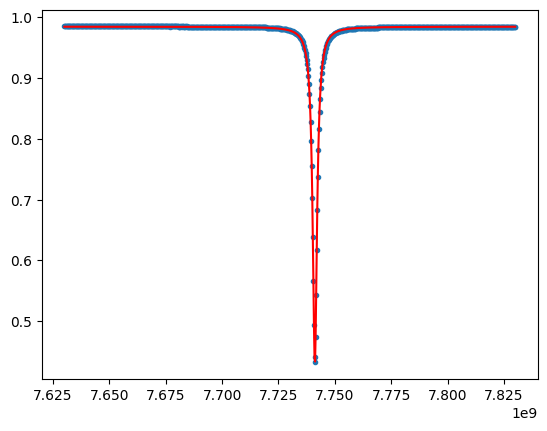

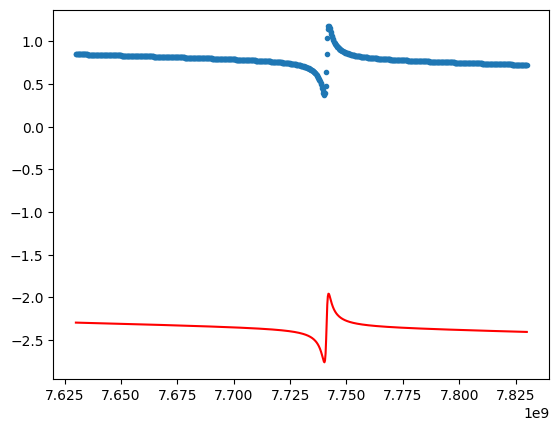

In [67]:
mag, phase, freq = sqil.extract_h5_data(good, ['mag', 'phase', 'frequency'])
mag, phase, freq = mag[0,:], phase[0,:], freq[0,:]

linmag = 10 ** (mag / 20)
phase = np.unwrap(phase)
data = linmag * np.exp(1j * phase)

delay, amp_norm, alpha, fr, Ql, A2, frcal = do_calibration(freq, data, ignoreslope=True, guessdelay=True)
z_data = do_normalization(freq,data,delay,amp_norm,alpha,A2,frcal)
fitresults = circlefit(freq, z_data, fr,Ql,refine_results=False,calc_errors=True)
z_data_sim = A2*(freq-frcal)+S11_directrefl(freq,fr=fitresults["fr"],Ql=fitresults["Ql"],Qc=fitresults["Qc"],a=amp_norm,alpha=alpha,delay=delay)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(freq, np.abs(data), '.')
plt.plot(freq, np.abs(z_data_sim), 'red')

plt.figure()
plt.plot(freq, np.angle(data), '.')
plt.plot(freq, np.angle(z_data_sim), 'red')

print(fitresults["fr"],fitresults["Ql"],fitresults["Qc"])

plt.show()

## Modified

In [74]:
def circlefit(f_data,z_data,fr=None,Ql=None,refine_results=False,calc_errors=True):
    '''
    S11 version of the circlefit
    '''

    if fr==None: fr=f_data[np.argmin(np.absolute(z_data))]
    if Ql==None: Ql=1e6
    xc, yc, r0 = fit_circle(z_data,refine_results=refine_results)
    phi0 = -np.arcsin(yc/r0)
    theta0 = periodic_boundary(phi0+np.pi,np.pi)
    z_data_corr = center(z_data,complex(xc,yc))
    theta0, Ql, fr = phase_fit(f_data,z_data_corr,theta0,Ql,fr)
    #print("Ql from phasefit is: " + str(Ql))
    # Qi = Ql/(1.-r0)
    # Qc = 1./(1./Ql-1./Qi)
    Qc=Ql/(r0*np.exp(-1j*phi0))
    Qi=1/(1/Ql-1/np.real(Qc))

    results = {"Qi":Qi,"Qc":Qc,"Ql":Ql,"fr":fr,"theta0":theta0, "phi0":phi0}

    #calculation of the error
    p = [fr,Qc,Ql]
    #chi_square, errors = rt.get_errors(rt.residuals_notch_ideal,f_data,z_data,p)
    if calc_errors==True:
        chi_square, cov = get_cov_fast_directrefl(f_data,z_data,p)
        #chi_square, cov = rt.get_cov(rt.residuals_notch_ideal,f_data,z_data,p)

        if cov is not None:
            errors = np.sqrt(np.diagonal(cov))
            fr_err,Qc_err,Ql_err = errors
            #calc Qi with error prop (sum the squares of the variances and covariaces)
            dQl = 1./((1./Ql-1./Qc)**2*Ql**2)
            dQc = - 1./((1./Ql-1./Qc)**2*Qc**2)
            Qi_err = np.sqrt((dQl**2*cov[2][2]) + (dQc**2*cov[1][1])+(2*dQl*dQc*cov[2][1]))  #with correlations
            errors = {"Ql_err":Ql_err, "Qc_err":Qc_err, "fr_err":fr_err,"chi_square":chi_square,"Qi_err":Qi_err}
            results.update( errors )
        else:
            print("WARNING: Error calculation failed!")
    #else:
    #    #just calc chisquared:
    #    fun2 = lambda x: residuals_notch_ideal(x,f_data,z_data)**2
    #    chi_square = 1./float(len(f_data)-len(p)) * (fun2(p)).sum()
    #    errors = {"chi_square":chi_square}
    #    results.update(errors)

    return results

def S11_directrefl(f,fr=10e9,Ql=900,Qc=1000.,a=1.,alpha=0.,delay=.0, phi=0):
    '''
    full model for notch type resonances
    '''

    return a*np.exp(complex(0,alpha))*np.exp(-2j*np.pi*f*delay) * ( 1-2*Ql/np.abs(Qc)*np.exp(1j*phi)/(1+2j*Ql*(f/fr-1)) )

7741150756.532712 2729.3073358696624 (9671.304590676658+92.38110894313314j)


C:\Users\duina\AppData\Local\Temp\ipykernel_27304\2105727276.py:66: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  p_final = spopt.leastsq(residuals,delay,args=(f_data,z_data),maxfev=maxiter,ftol=1e-12,xtol=1e-12)
C:\Users\duina\AppData\Local\Temp\ipykernel_27304\2511080271.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fr = float(p_final[0])
C:\Users\duina\AppData\Local\Temp\ipykernel_27304\2511080271.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ql = float(p_final[0])


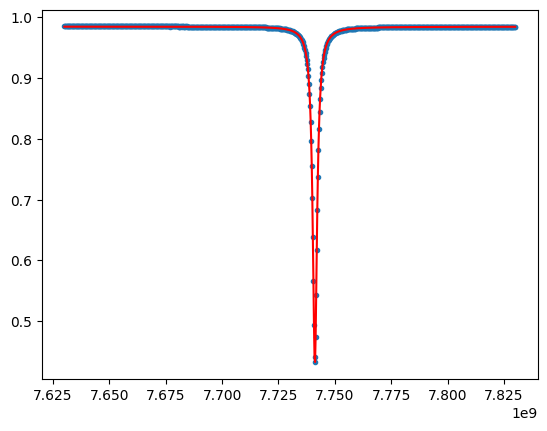

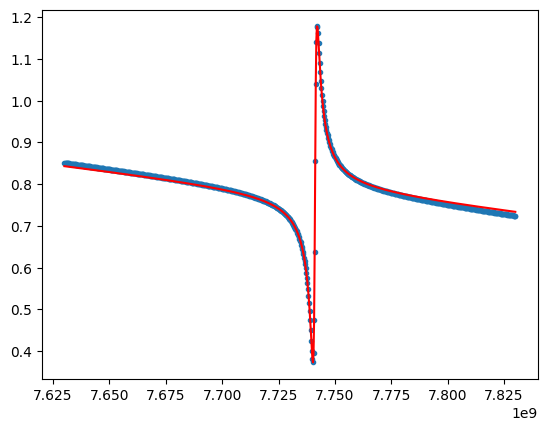

In [77]:
mag, phase, freq = sqil.extract_h5_data(good, ['mag', 'phase', 'frequency'])
mag, phase, freq = mag[0,:], phase[0,:], freq[0,:]

linmag = 10 ** (mag / 20)
phase = np.unwrap(phase)
data = linmag * np.exp(1j * phase)

delay, amp_norm, alpha, fr, Ql, A2, frcal = do_calibration(freq, data, ignoreslope=True, guessdelay=True)
z_data = do_normalization(freq,data,delay,amp_norm,alpha,A2,frcal)
fitresults = circlefit(freq, z_data, fr,Ql,refine_results=False,calc_errors=False)
z_data_sim = A2*(freq-frcal)+S11_directrefl(freq,fr=fitresults["fr"],Ql=fitresults["Ql"],Qc=fitresults["Qc"],a=amp_norm,alpha=alpha,delay=delay, phi=fitresults["phi0"])


import matplotlib.pyplot as plt
plt.figure()
plt.plot(freq, np.abs(data), '.')
plt.plot(freq, np.abs(z_data_sim), 'red')

plt.figure()
plt.plot(freq, np.angle(data), '.')
plt.plot(freq, np.angle(z_data_sim), 'red')

print(fitresults["fr"],fitresults["Ql"],fitresults["Qc"])

plt.show()